In [1]:
import os, time, errno
import torch, tables
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='1'
savedir = '64x64-convnet'

In [3]:
T = 10 # time buckets

hdf5 = tables.open_file('captures/fei/R1_E3_AMES_200min_200f_14l_rgb.h5','r')
hdf5 = hdf5.root

try:
    dataset = np.load('captures/fei/cache.npy')
except FileNotFoundError:

    data = []
    for i in range(7):
        print('.',end='')
        batch = np.array(hdf5['data'][i*400:(i+1)*400])
        batch = batch.reshape(-1,T,int(batch.shape[1]/T),64,64,6).sum(2).astype(np.float32) # binning
        data.append(batch)
        
    dataset = np.concatenate(data,axis=0)
    dataset = np.moveaxis(dataset,[0,1,2,3,4],[0,1,3,4,2])
    np.save('captures/fei/cache.npy', dataset)
    
classes = np.array([np.array(itm.decode('utf-8').split('"'))[[1,3]].astype(np.int32)
                    for itm in np.array(hdf5['image_classes'].read())])

# Presented targets

In [4]:
imgs = hdf5["images"][0:100]
y,x = np.where(np.mean(imgs, axis=(0,3))>5)
xleft, xright, ytop, ybot = min(x), max(x), min(y), max(y)

images = hdf5["images"][:,ytop:ybot,xleft:xright]

tiny_images = []
for i in range(len(images)):
    tiny_images.append(cv2.resize(images[i],(64,64)))
images = np.stack(tiny_images)

# Model

In [5]:
class Block(torch.nn.Module):
    def __init__(self, filters):
        super(Block, self).__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters), torch.nn.ReLU(),
            torch.nn.Conv2d(filters, filters, 3, padding=1, bias=False),
            torch.nn.BatchNorm2d(filters))
        
    def forward(self, x):
        return F.relu(x + self.block(x))
    
class ConvNet(torch.nn.Module):
    def __init__(self, filters=128):
        super(ConvNet, self).__init__()
        self.filters = filters
        
        self.conv_in = torch.nn.Conv2d(10*6, filters, 9, padding=4, stride=4, bias=False)
        
        self.resnet = torch.nn.ModuleList()
        for i in range(101): self.resnet.append(Block(filters))
            
        self.conv_out =  torch.nn.ConvTranspose2d(self.filters, 1, 4, stride=4, bias=True)
        self.bias = torch.nn.Parameter(torch.Tensor(64,64))
        
        for name, parm in self.named_parameters():
            if name.endswith('weight'): torch.nn.init.normal_(parm, 0, .01)
            if name.endswith('bias'): torch.nn.init.constant_(parm, 0.0)
    
    def forward(self, x):
        x = x.view(-1,10*6,64,64)
        zx = F.relu(self.conv_in(x))
        for layer in self.resnet: zx = layer(zx)
        return torch.sigmoid(self.conv_out(zx).squeeze() + self.bias[None,:,:])

# Fit

In [6]:
data = torch.tensor(dataset)/30. # scaling
targets = torch.tensor(images).float().mean(3)/255.

In [7]:
train_data = data[[i for i in range(2800) if (i+1)%5 != 0]]
val_data = data[slice(4,2800,10)]
test_data = data[slice(9,2800,10)]

train_targets = targets[[i for i in range(2800) if (i+1)%5 != 0]]
val_targets = targets[slice(4,2800,10)]
test_targets = targets[slice(9,2800,10)]

In [8]:
batch_size = 50

model = ConvNet().cuda()
count = sum([np.prod(parm.shape) for parm in model.parameters() if parm.requires_grad])
print('Initialized a graph with {} parameters'.format(count))

train_history = []
val_history = []

model.eval()
loss = 0.
for i in np.random.permutation(len(val_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).sum(1).mean()
val_history.append(loss/(len(val_data)//batch_size))
print('Initial Loss: {:2f}'.format(val_history[-1]))

Initialized a graph with 30466049 parameters
Initial Loss: 4.065942


In [9]:
batch_size = 50
optimizer = torch.optim.Adam(model.parameters(), lr=.0003)

try:
    print('epoch\ttrain loss\ttest loss\ttime\t\tutime')
    t0 = time.time()
    for epoch in range(800):
        model.train()
        loss_train = 0
        for i in np.random.permutation(len(train_data)//batch_size):
            start, end = i*batch_size, (i+1)*batch_size
            x,z = train_data[start:end].cuda(), train_targets[start:end].cuda()
            loss = ((model(x) - z)**2).sum(1).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.detach()
        train_history.append(loss_train/(len(train_data)//batch_size))

        if epoch % 1 == 0:
            t1 = time.time()
            model.eval()
            loss = 0.
            for i in range(len(val_data)//batch_size):
                start, end = i*batch_size, (i+1)*batch_size
                x,z = val_data[start:end].cuda(), val_targets[start:end].cuda()
                loss += ((model(x).detach() - z)**2).sum(1).mean()
            val_history.append(loss/(len(val_data)//batch_size))
            print('{:d}\t{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(epoch,train_history[-1],val_history[-1],time.time()-t0, time.time()-t1))
            t0 = time.time()
            
except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print('Finished')

epoch	train loss	test loss	time		utime
0	2.329604	4.019663	23.765071	0.800390
1	1.278133	2.181040	24.166732	0.812580
2	1.065705	1.479056	24.536466	0.820822
3	0.980110	1.222847	25.082625	0.838110
4	0.850692	1.014971	25.390574	0.845187
5	0.765293	0.930823	25.483544	0.842734
6	0.705511	0.878064	25.475939	0.845190
7	0.632511	0.838755	25.582600	0.849792
8	0.617654	0.943655	25.666464	0.852526
9	0.587151	0.901017	25.721429	0.837825
10	0.544225	0.791886	25.820598	0.854889
11	0.492069	0.765670	25.871120	0.855408
12	0.470316	0.801238	25.905003	0.850161
13	0.446923	0.819011	25.941255	0.859599
14	0.410185	0.735115	25.913767	0.836210
15	0.417009	0.754366	25.962221	0.859549
16	0.402044	0.727509	25.937635	0.849061
17	0.376369	0.686057	25.960482	0.861066
18	0.371370	0.753358	25.922855	0.855642
19	0.364879	0.758194	25.953799	0.859832
20	0.411386	0.836066	25.952577	0.849483
21	0.356535	0.685361	25.964458	0.859338
22	0.331100	0.649961	25.928187	0.850036
23	0.303066	0.710412	25.930482	0.854239
24	0.324397

202	0.042250	0.647399	25.321734	0.840348
203	0.040243	0.635991	25.295039	0.838644
204	0.036911	0.634621	25.313287	0.841948
205	0.034707	0.619398	25.291497	0.837949
206	0.034372	0.618517	25.294453	0.839641
207	0.033897	0.628478	25.266667	0.830979
208	0.033363	0.622091	25.301481	0.844023
209	0.033078	0.631132	25.285968	0.840398
210	0.034450	0.638653	25.270686	0.839867
211	0.035713	0.626254	25.292374	0.840099
212	0.043586	0.631098	25.290996	0.842038
213	0.057587	0.632382	25.265020	0.841422
214	0.060427	0.646741	25.295647	0.839016
215	0.056339	0.640190	25.273461	0.837645
216	0.057425	0.626752	25.276542	0.838038
217	0.054978	0.624433	25.285615	0.840954
218	0.045955	0.636151	25.227237	0.840197
219	0.041833	0.622255	25.233243	0.839916
220	0.040644	0.627942	25.240601	0.838385
221	0.039035	0.616411	25.223624	0.840433
222	0.037833	0.624060	25.225760	0.839336
223	0.038726	0.627286	25.233239	0.835790
224	0.041982	0.643826	25.223482	0.838651
225	0.043889	0.615448	25.230999	0.837656
226	0.042885	0.6

402	0.025961	0.621330	25.794923	0.849207
403	0.024739	0.619619	25.798086	0.852469
404	0.024078	0.608379	25.817058	0.851611
405	0.019953	0.597099	25.799867	0.851821
406	0.015815	0.600722	25.827899	0.852453
407	0.013196	0.595410	25.823554	0.848731
408	0.012479	0.601062	25.815591	0.846467
409	0.011324	0.598422	25.798948	0.828559
410	0.010622	0.595452	25.848017	0.851655
411	0.009857	0.603423	25.817432	0.851230
412	0.009560	0.595692	25.816674	0.851841
413	0.009557	0.596316	25.837271	0.855077
414	0.009747	0.612781	25.805116	0.850848
415	0.011030	0.595149	25.802557	0.847727
416	0.012022	0.603352	25.807493	0.829584
417	0.011729	0.591324	25.842332	0.852097
418	0.011936	0.594267	25.806841	0.853932
419	0.012742	0.600690	25.812222	0.853018
420	0.013717	0.603338	25.798692	0.847010
421	0.014963	0.599613	25.770752	0.829807
422	0.014937	0.607467	25.825835	0.850793
423	0.014739	0.603363	25.839132	0.853235
424	0.014442	0.599224	25.868074	0.850472
425	0.014345	0.610177	25.851606	0.847270
426	0.016368	0.6

602	0.005338	0.589664	25.236813	0.839554
603	0.005420	0.588520	25.227876	0.838751
604	0.005578	0.584590	25.225078	0.838605
605	0.005501	0.587805	25.234344	0.840045
606	0.005496	0.588170	25.247062	0.840991
607	0.005787	0.583671	25.278036	0.841443
608	0.006346	0.595272	25.288289	0.840700
609	0.006970	0.602995	25.273996	0.838717
610	0.007871	0.586302	25.263833	0.840964
611	0.008533	0.597255	25.254273	0.841204
612	0.009063	0.585824	25.290253	0.841843
613	0.010567	0.602009	25.282198	0.834080
614	0.013706	0.600818	25.287308	0.836106
615	0.026262	0.613534	25.270721	0.841029
616	0.041495	0.650243	25.287984	0.839071
617	0.041282	0.601160	25.276027	0.839331
618	0.027084	0.605210	25.265477	0.839003
619	0.018299	0.592643	25.283516	0.836733
620	0.012108	0.592592	25.253762	0.837856
621	0.008514	0.586364	25.238361	0.837638
622	0.006595	0.581508	25.227194	0.837802
623	0.005675	0.580690	25.231326	0.840195
624	0.005129	0.584627	25.223077	0.837131
625	0.004810	0.584804	25.221887	0.837723
626	0.004596	0.5

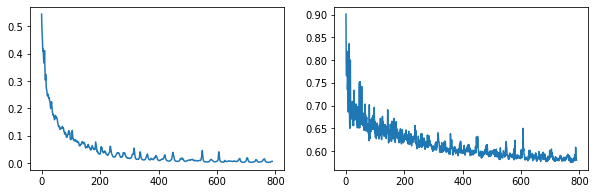

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].plot([itm.cpu().numpy() for itm in train_history[10:]])
ax[1].plot([itm.cpu().numpy() for itm in val_history[10:]])

In [11]:
model.eval()
loss = 0.
for i in np.random.permutation(len(test_data)//batch_size):
    start, end = i*batch_size, (i+1)*batch_size
    x,z = test_data[start:end].cuda(), test_targets[start:end].cuda()
    loss += ((model(x).detach() - z)**2).view(-1,64*64).sum(1).mean()
print('Final Loss: {:2f}'.format(loss/(len(test_data)//batch_size)))

Final Loss: 36.593761


In [12]:
try:
    os.makedirs(f'final-outputs/{savedir}')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

originals = False
try:
    os.makedirs('final-outputs/originals')
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    originals = True

train_idx = 0
val_idx = 0
test_idx = 0
for i in range(len(data)):
    person, pose = classes[i]
    if (i+1) % 5 != 0: # training data
        prefix = f'train{train_idx}'
        train_idx += 1
    elif (i+1) % 10 == 5: # validation data
        prefix = f'valid{val_idx}'
        val_idx += 1
    else: # (i+1) % 10 == 0 (test data)
        prefix = f'test{test_idx}'
        test_idx += 1
    
    recon = model(data[i].cuda()).detach().cpu().numpy()[0]
    cv2.imwrite(f'final-outputs/{savedir}/{prefix}-person{person}-pose{pose}.png', 255*recon)
    if not originals:
        cv2.imwrite(f'final-outputs/originals/{prefix}-person{person}-pose{pose}.png', 255*targets[i].numpy())

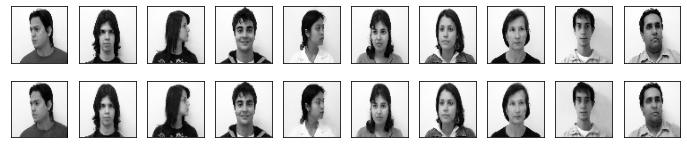

In [13]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(train_data[0:10].cuda()).detach().cpu()
for i in range(10):
    ax[0,i].imshow(train_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])

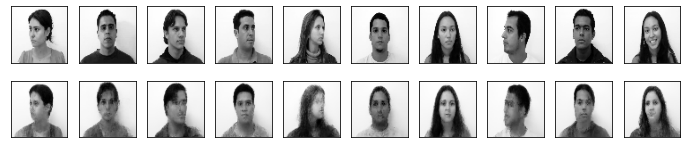

In [14]:
fig, ax = plt.subplots(2,10, figsize=(12,2.5))

model.eval()
reconstructions = model(test_data[0:10].cuda()).detach().cpu()
for i in range(10):    
    ax[0,i].imshow(test_targets[i],cmap='Greys_r')
    ax[0,i].set_xticks([]); ax[0,i].set_yticks([])
    
    ax[1,i].imshow(reconstructions[i],cmap='Greys_r')
    ax[1,i].set_xticks([]); ax[1,i].set_yticks([])